In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import datetime

import gym
import trading_env

import os
import agent 
from os import __file__

Using TensorFlow backend.


Loading historical data file


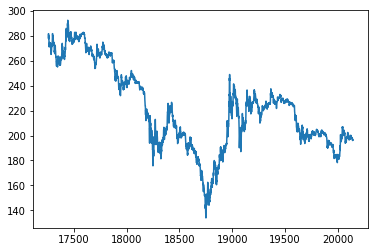

In [2]:
env_trading = gym.make('test_trading-v0')
NUM_EP = 700
date = datetime.datetime(2017, 7, 1, 0, 0)
data = env_trading.historical_data["close"]
env_trading.reset(date=date)
plt.plot(data[env_trading.start_index:env_trading.start_index + int(env_trading.episode_steps) 
              if env_trading.start_index + int(env_trading.episode_steps) < data.shape[0]
             else data.shape[0]])

plt.show()

## The Goal
Have a better cumulated reward and final portfolio value than the three following agents:
- The "holder" (action = 1)
- The "All out" (action = -1)
- The "I have no idea what I am doing" (random action)


# Holder

In [3]:
state = env_trading.reset(date=date)
total_reward = 0

while(True):
    action = 1.0 #Holder agent
    state, reward, done, _ = env_trading.step(action)
    total_reward += reward
    if done:
        break
holder_reward = np.full(NUM_EP, total_reward)

# Random

In [4]:
state = env_trading.reset(date=date)
total_reward = 0

while(True):
    action = env_trading.action_space.sample()
    state, reward, done, _ = env_trading.step(action)
    total_reward += reward
    if done:  
        break
random_reward = np.full(NUM_EP, total_reward)

# All out

In [5]:
out_reward = np.full(NUM_EP, 0)

# The Agent

### Stochastic Policy Gradient

In [ ]:
agentSPG = agent.StochasticPolicyGradientAgent(env_trading, learning_rate = 1e-4, 
                                               discount_rate = 0.99, batch_size = 64)

In [ ]:
rewards_plot = []
portfolio = []
for i in range(NUM_EP):
    state = env_trading.reset(date=date)
    state = np.reshape(state,200)
    total_reward = 0
    
    while(True):
        action = agentSPG.act([state])
        state, reward, done, _ = env_trading.step(action)
        state = np.reshape(state,200)
        agentSPG.store_step(action, state, reward)
        total_reward += reward
        if done:
            rewards_plot.append(total_reward)
            portfolio.append(env_trading.portfolio_value)
            print("Episode: {}, Total reward: {}".format(i,total_reward))
            break
    agentSPG.train()


In [ ]:
plt.plot(rewards_plot, label = "Trained agent")
plt.plot(holder_reward, label = "Holder")
plt.plot(random_reward, label = "Random")
plt.plot(out_reward, label = "All out")
plt.legend()
plt.show()

### Deep Q Network

In [6]:
agentDQN = agent.DQNAgent(env_trading, alpha = 1e-5)

In [7]:
scores = []
rewards_plot = []

for e in range(NUM_EP):

    state = np.reshape(env_trading.reset(date=date), [1, 200])
    score = 0

    while(True):
        action = agentDQN.act(state, e)
        next_state, reward, done, _ = env_trading.step(action - 1) #Converting class to action
        next_state = np.reshape(next_state, [1, 200])

        agentDQN.store_step(state, action, reward, next_state, done)

        state = next_state

        score += reward

        if done:
            rewards_plot.append(score)
            print("Episode: {}, Total reward: {}".format(e, score))
            break
    
    agentDQN.train()

Episode: 0, Total reward: 0.0
Episode: 1, Total reward: -11.744748108942343
Episode: 2, Total reward: 4.158463334339022
Episode: 3, Total reward: 36.02022187356437
Episode: 4, Total reward: -17.03728057566301
Episode: 5, Total reward: -22.56232208085472
Episode: 6, Total reward: 20.682665181372908
Episode: 7, Total reward: 4.383322682469309
Episode: 8, Total reward: 9.501297563092288
Episode: 9, Total reward: 13.967957227285828
Episode: 10, Total reward: 10.797646336793635
Episode: 11, Total reward: 8.38646028769766
Episode: 12, Total reward: 10.826249057169386
Episode: 13, Total reward: 5.440419558238997
Episode: 14, Total reward: 9.841889940261028
Episode: 15, Total reward: 7.542873041454987
Episode: 16, Total reward: 8.691408904142833
Episode: 17, Total reward: 6.861142503395559
Episode: 18, Total reward: 5.977944527336478
Episode: 19, Total reward: 10.311975471109632
Episode: 20, Total reward: 9.780463634054188
Episode: 21, Total reward: 9.766231890155403
Episode: 22, Total reward:

Episode: 181, Total reward: 9.285799227941105
Episode: 182, Total reward: 10.506743579446349
Episode: 183, Total reward: 10.075537526191019
Episode: 184, Total reward: 10.219536919877767
Episode: 185, Total reward: 10.219536919877767
Episode: 186, Total reward: 10.092334654074715
Episode: 187, Total reward: 7.713588478788568
Episode: 188, Total reward: 7.293206748370021
Episode: 189, Total reward: 8.115451526899907
Episode: 190, Total reward: 7.307454876527406
Episode: 191, Total reward: 6.7940593938811356
Episode: 192, Total reward: 7.966621254086034
Episode: 193, Total reward: 7.693640923505821
Episode: 194, Total reward: 8.501204150401774
Episode: 195, Total reward: 7.03479897629681
Episode: 196, Total reward: 7.095794710541164
Episode: 197, Total reward: 9.280500956428002
Episode: 198, Total reward: 10.268203984779127
Episode: 199, Total reward: 9.474083926277306
Episode: 200, Total reward: 8.626435534043102
Episode: 201, Total reward: 6.83948358651526
Episode: 202, Total reward: 7

KeyboardInterrupt: 

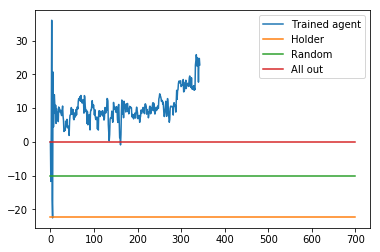

In [8]:
plt.plot(rewards_plot, label = "Trained agent")
plt.plot(holder_reward, label = "Holder")
plt.plot(random_reward, label = "Random")
plt.plot(out_reward, label = "All out")
plt.legend()
plt.show()

The DQN agent is able to have a greater cumulated reward than the 3 other agents.